# Машинное обучение, DS-поток
## Домашнее задание 8

---

См. сначала **`[0]task8_train_model.ipynb`**, в котором описана структура этого задания.  

После выполнения этого ноутбука см. **`[2]task8_test_modules.ipynb`** для проверки работы всех компонент.

## Мотивация

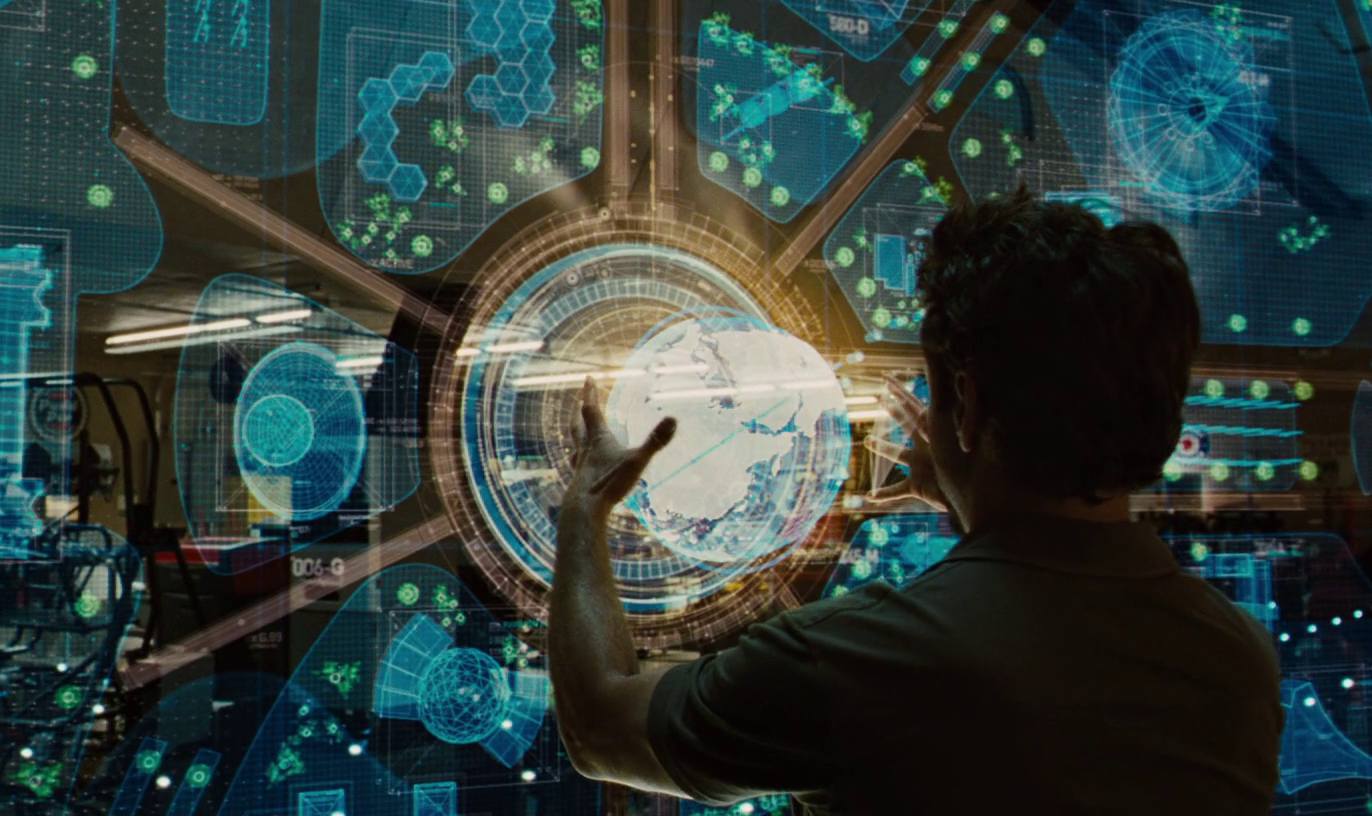

Мы хотим построить "с нуля" свой мини-фреймворк для обучения нейронных сетей. Он должен позволять создавать, обучать и тестировать нейросети. Как известно из лекции и семинара, **цикл обучения нейросети** выглядит так:

```
# однослойная нейросеть 
model = Sequential()
model.add(Linear(2,2))
model.add(LogSoftMax())

criterion = NLLCriterion()

optimizer = SGD(lr=1e-2, momentum=0.9)

# одна эпоха -- один проход по обучающей выборке
for i in range(n_epoch):
    # одна итерация -- один батч
    for x_batch, y_batch in train_generator(sample, labels, batch_size):
        # Обнуляем градиенты с предыдущей итерации
        model.zero_grad_params()
        # Forward pass
        predictions = model.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
        # Backward pass
        last_grad_input = criterion.backward(predictions, y_batch)
        model.backward(x_batch, last_grad_input)
        # Обновление весов
        optimizer(
            model.get_params(), 
            model.get_grad_params(), 
            opt_params,
            opt_state
        )
 ```
 
Одна итерация внутреннего цикла называется **одной итерацией обучения нейросети**. Одна итерация внешнего цикла называется **одной эпохой обучения нейросети**.

## Проектирование фреймворка 

### Базовые концепции

**Нейросеть** $-$ это последовательность слоев. В реализации ее удобно представлять абстракцией `Sequential`. 

**Слой** $-$ это некоторая функция, у которой в общем случае есть обучаемые параметры. Есть слои и без обучаемых параметров (например, функции активации, SoftMax, LogSoftMax, MaxPool2d), однако все эти функции все равно удобно называть слоями нейросети. В реализации один слой удобно представлять абстракцией `Module`.  Например, `Sequential(Linear, ReLU)` -- это уже три модуля.

Каждый слой должен уметь делать прямой проход **forward pass**, и обратный проход **backward pass**. В реализации forward pass удобно представлять абстрактным методом `forward()`, backward pass удобно представлять абстрактным методом `backward()`.

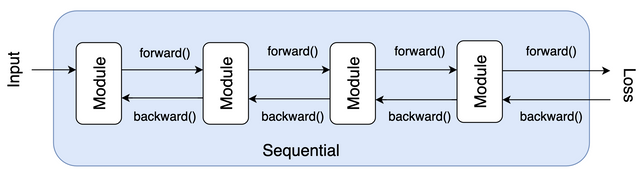

### Forward pass

Forward pass является *первым этапом итерации обучения нейросети*. После выполнения этого этапа сеть должна выдать вычисленное преобразование входа.

Во время вызова метода `forward()` у `Sequential`, вход, поданный нейросети, проходит через все ее слои "вперед", до выходного слоя.

Во время вызова метода `forward()` у `Module`, над входом, поданным слою, осуществляется операция этого слоя (линейная, дропаут, софтмакс, батчнорм).

В реализации ниже у каждого слоя во время `forward()` будет вызываться только один метод $-$ `update_output()`, который и производит вычисление операции слоя. Важно отметить, что при вызове `update_output()` его выход **сохраняется в поле `self.output`** вызвавшего слоя. Это необходимо, поскольку выходы слоёв потом используются в **backward pass**.

### Backward pass

#### Теоретическая справка

Backward pass является *вторым этапом итерации обучения нейросети*. В современном глубоком обучении backward pass является реализацией метода **[Error Backpropagation](https://en.wikipedia.org/wiki/Backpropagation)** (backprop), по-русски **"Метод обратного распространения ошибки"**. После выполнения этого этапа у каждого параметра каждого слоя нейронной сети должны быть посчитаны градиенты на текущей итерации. 

**Первая идея** Backpropagation состоит в использования **градиентных методов оптимизации**, например, стохастического градиентного спуска. Однако чтобы посчитать градиент функции потерь $L$ по параметрам ранних слоев в нейросети, придется иметь дело с "очень сложной" функцией:

$$
\frac{\partial L}{\partial W_1} = \frac{\partial (\varphi_s(W_n\varphi_{s-1}(W_{s-1}\varphi_{s-2}(...\varphi_{1}(W_1 x)))) - y)^2}{\partial W_1}
$$

где $W_k$ $-$ матрица весов $k$-го слоя, $\varphi_k$ $-$ функция активации $k$-го слоя. И это при том, что здесь все слои $-$ линейные. Для более сложных слоев (например, свёрточных) эта функция будет еще сложнее.  

Поэтому **вторая идея** Backpropagation состоит в использовании **правила цепочки (chain rule)**, примененного в отношении градиента функции потерь по каждому из параметров каждого слоя нейросети. Рассмотрим конкретный слой под номером $k$ и следующим за ним слой $k+1$. Пусть это оба $-$ линейные слои, линейный слой $k$ осуществляет операцию $O_k = x_k W_k$, где $x_k \in \mathbb{R}^{n \times d}$ $-$ вход слоя, $W_k \in \mathbb{R}^{d \times m}$ $-$ веса слоя, $O_k \in \mathbb{R}^{n \times m}$ $-$ выход слоя. Тогда чтобы обновить его веса $W_k$ выпишем правило цепочки:

$$
\frac{\partial L}{\partial W_k} = \frac{\partial L}{\partial O_k} \frac{\partial O_k}{\partial W_k} = \frac{\partial L}{\partial O_k} x_k
$$

Видим, что для вычисления градиента лосса по $W_k$ нам нужно посчитать $\frac{\partial L}{\partial O_k}$, то есть градиент лосса по выходу этого слоя. **Если слой $k$ является последним (выходным)** в нейросети (то есть $k+1$-го слоя уже нет), то ответ имеет вид:

$$
\frac{\partial L}{\partial O_k} = \frac{\partial L}{\partial \widehat{y}_k}
$$

И сразу же достигаем цели. Однако **если слой $k$ $-$ это какой-то из скрытых слоев**, то мы не можем сразу посчитать $\frac{\partial L}{\partial O_k}$ $-$ придем к той же проблеме "очень сложной" функции, описанной выше.  

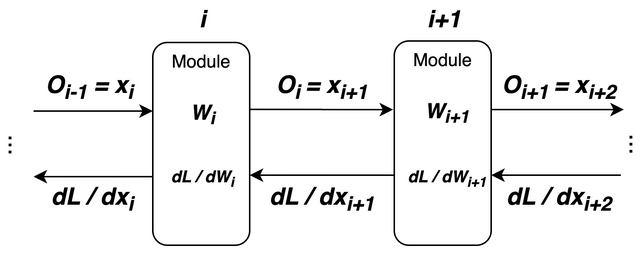

Поэтому чтобы реализовать правило цепочки, делается такой "трюк": заметим, что **выход слоя $k$ является входом для слоя $k+1$**, то есть $O_k = x_{k+1}$. И тогда будем для каждого слоя считать не только $\frac{\partial L}{\partial W_{k+1}}$ для обновления весов, но и $\frac{\partial L}{\partial x_{k+1}}$ для передачи градиента по входу слоя $k+1$ в виде градиента по выходу $\frac{\partial L}{\partial O_k}$ слоя $k$:

$$
\frac{\partial L}{\partial x_{k+1}} = \frac{\partial L}{\partial O_{k+1}} \frac{\partial O_{k+1}}{\partial x_{k+1}} = \frac{\partial L}{\partial O_{k+1}} W_{k+1}   
$$

Делая так для **каждого** слоя, мы получим возможность как бы **рекурсивно** обновлять параметры (веса) всех слоев, как только получим $\frac{\partial L}{\partial \hat{y_k}}$ от последнего слоя.

#### Реализация

Во время вызова метода `backward()` у `Sequential` мы в цикле вычисляем `backward()` для всех слоев нейросети в соответствии с описанной выше схемой реализации правила цепочки.

Во время вызова метода `backward()` у `Module` вызываются два метода $-$ `update_grad_params()` и `update_grad_input()`.

`update_grad_params()` вычисляет $\frac{\partial O_k}{\partial W_k}$ $-$ градиент выхода слоя по параметрам $W_k$.

`update_grad_input()` вычисляет $\frac{\partial O_k}{\partial x_k}$ $-$ градиент выхода слоя по входу $x_k$, чтобы передать потом этот градент слою $k-1$ в виде `grad_output`.

***Важно:*** в chain rule присутствуют произведения градиентов. Они могут быть векторами/матрицами, поэтому при умножении следует использовать именно **матричное произведение**, если выводите формулы через прозводную по вектору/матрице. Если же выводите "поэлементно" (как в примере с `LogSoftMax`), то форма произведений будет видна из вывода.

Обратите внимание на то, что в цикле обучения выше (под картинкой в начале раздела "Мотивация") `last_grad_input` $-$ это градиент слоя `criterion` по его входу, и он же является `grad_output` для всей нейросети `model` $-$ градиентом, приходящим от "следующего слоя". Это полностью согласуется с методом обратного распространения ошибки, который мы только что обсудили, если считать функцию потерь (`criterion`) "фиктивным" слоем нейросети.

*Примечание*: вообще говоря, сам метод обновления весов нейросети не обязан быть gradient-based, каким является backprop. Например, это могут быть [эволюционные методы](https://arxiv.org/pdf/1712.06567.pdf), или относительно недавний Equilibrium propagation, см. [ответ на StackOverflow](https://stackoverflow.com/questions/55287004/are-there-alternatives-to-backpropagation).

### Обновление весов

Обновление весов (оптимизация) является *третьим, последним этапом итерации обучения нейросети*. После выполнения этого этапа все обучаемые параметры всех слоев нейросети должны изменить свое значение (обновиться) в соответствие с правилами данного конкретного оптимизатора.

В реализации ниже вам нужно написать только один оптимизатор $-$ `SGD`. Это метод стохастического градиентного спуска с `momentum`.

## Реализация (20 баллов)

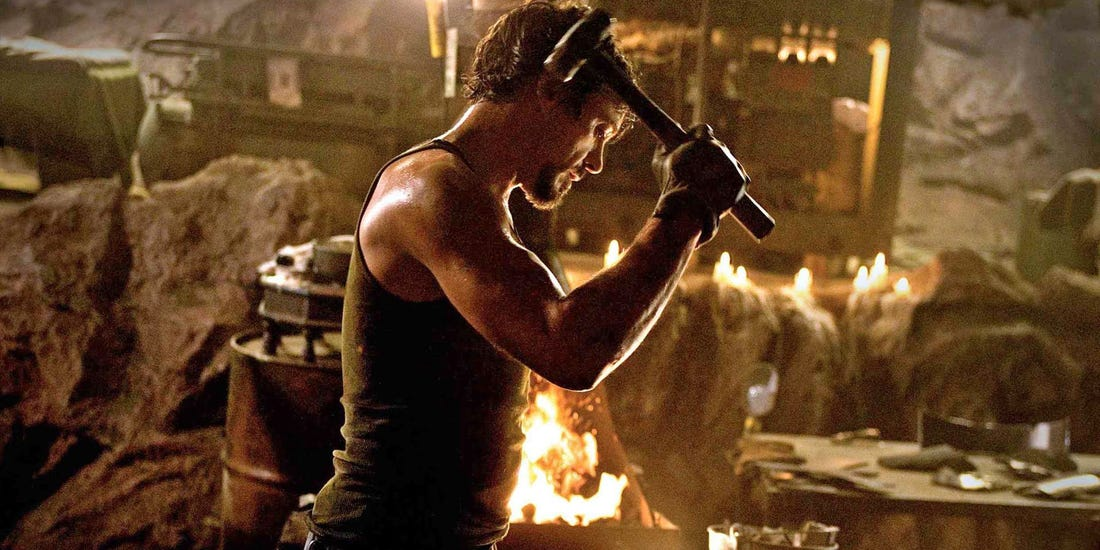

Далее вам предстоит реализовать все компоненты нейронной сети, используя **только библиотеку NumPy**:

> Базовые концепции:
- [x] `Module`     $-$ абстрактный класс для компонент нейронной сети;
- [ ] *(2 балл)* `Sequential` $-$ класс, содержащий в себе последовательность объектов класса `Module`.

> Слои:
- [ ] *(2 балла)* `Linear`     $-$ линейный слой;
- [ ] *(3 балла)* `SoftMax`    $-$ слой, вычисляющий операцию *softmax*;
- [x] `LogSoftMax` $-$ слой, вычисляющий операцию *log(softmax)*;
- [ ] *(2 балл)*  `Dropout`    $-$ слой дропаута;
- [ ] *(3 балла)* `BatchNormalization` $-$ слой для работы слоя батч-нормализации;
- [x] `Scaling`    $-$ слой для работы слоя батч-нормализации;
- [x] `Flatten`    $-$ слой, который просто "разворачивает" тензор любой размерности в одномерный вектор.

> Функции активации (тоже являются слоями, но выделены в отдельную секцию для удобства):
- [x] `ReLU`      $-$ функция активации *Rectified Linear Unit*;
- [ ] *(1 балл)* `LeakyReLU` $-$ функция активации *Leaky Rectified Linear Unit*;
- [ ] *(1 балл)* `ELU`       $-$ функция активации *Exponential Linear Unit*;
- [ ] *(1 балл)* `Softplus`  $-$ функция активации *Softplus*.

> Функции потерь:
- [x] `Criterion`  $-$ абстрактный класс для функций потерь;
- [ ] *(1 балл)* `MSECriterion`         $-$ среднеквадратичная функция потерь;
- [ ] *(1 балл)* `NLLCriterionUnstable` $-$ negative log-likelihood функция потерь (нестабильная версия, возможны числовые переполнения);
- [x] *(1 балл)* `NLLCriterion` $-$ negative log-likelihood функция потерь (стабильная версия).

> Оптимизаторы:
- [ ] *(2 балла)* `SGD`  $-$ метод стохастического градиентного спуска (включая `momentum`).

Перед каждым слоем напоминается формула его forward pass. В уже реализованных за вас модулях (отмечены галочкой) формулы для вычисления backward pass тоже уже даны, в остальных их нужно вывести самим по аналогии.

**В скобках перед названием слоя указаны баллы за его реализацию и за вывод формулы для backward pass. Они засчитываются только тогда, когда слой проходит все тесты в ноутбуке `[2]task8_test_modules.ipynb`**

In [ ]:
import numpy as np

##  Базовые концепции

### Module

**Module** $-$ абстрактный класс, который определяет методы, которые могут быть реализованы у каждого слоя.

Этот класс полностью реализован за вас. Пожалуйста, внимательно прочитайте методы и их описания, чтобы ориентироваться в дальнейшем.

In [ ]:
class Module(object):
    """
        Абстрактный класс для слоев нейросети.

        Как и описано в "Проектирование фреймворка":

        - во время forward просто вычисляет операцию слоя:

            `output = module.forward(input)`

        - во время backward дифференцирует функцию слоя по входу и по параметрам,
          возвращает градиент по входу этого слоя (для удобства):

            `grad_input = module.backward(input, grad_output)`
    """
    
    def __init__ (self):
        self.output = None
        self.grad_input = None
        self.training = True
    
    def forward(self, input):
        """
        Вычисляет операцию слоя.
        
        Вход: 
            `input (np.array)` -- вход слоя  
        Выход: 
            `self.update_output(input) (np.array)` -- вычисленная операция слоя
        """
        
        return self.update_output(input)

    def backward(self, input, grad_output):
        """
        Осуществляет шаг backpropagation'а для этого слоя,
        дифференцируя функцию слоя по входу и по параметрам.
        
        Обратите внимание, что градиент зависит и от параметров, от входа input.
        
        Вход: 
            `input (np.array)` -- вход слоя
            `grad_output (np.array)` -- градиент по выходу этого слоя, пришедший от следующего слоя
        Выход: 
            `self.grad_input (np.array)` -- градиент функции слоя по входу
        """
        
        self.update_grad_input(input, grad_output)
        self.update_grad_params(input, grad_output)
        return self.grad_input
    
    def update_output(self, input):
        """
        Конкретная реализация `forward()` для данного слоя.
        Вычисляет функцию слоя (линейную, `ReLU`, `SoftMax`) по входу `input`.
        
        Вход: 
            `input (np.array)` -- вход слоя
        Выход: 
            `self.output (np.array)` -- вычисленная операция слоя, сохраненная в поле класса 
            
        Важно! не забывайте как возвращать `self.output`, так и сохранять результат в это поле 
        """
        
        # The easiest case:
            
        # self.output = input 
        # return self.output
        
        pass

    def update_grad_input(self, input, grad_output):
        """
        Вычисляет градиент функции слоя по входу `input` и возвращает его в виде `self.grad_input`.
        Размер (`shape`) поля `self.grad_input` всегда совпадает с размером `input`.
        
        Вход: 
            `input (np.array)` -- вход слоя
            `grad_output (np.array)` -- градиент по выходу этого слоя, пришедший от следующего слоя
        Выход: 
            `self.grad_input (np.array)` -- вычисленный градиент функции слоя по входу `input`
        
        Важно! не забывайте как возвращать `self.grad_input`, так и сохранять результат в это поле 
        """
        
        # The easiest case:
        
        # self.grad_input = grad_output 
        # return self.grad_input
        
        pass   
    
    def update_grad_params(self, input, grad_output):
        """
        Вычисляет градиент функции слоя по параметрам (весам) этого слоя. 
        Ничего не возвращает, только сохраняет значения градиентов в соответствующие поля.
        Не нужно реализовывать этот метод, если у слоя нет параметров (у функций активации, 
        `SoftMax`, `LogSoftMax`, `MaxPool2d`).
        
        Вход: 
           `input (np.array)` -- вход слоя
            `grad_output (np.array)` -- градиент по выходу этого слоя, пришедший от следующего слоя
        """
        
        pass
    
    def zero_grad_params(self): 
        """
        Обнуляет градиенты у параметров слоя (если они есть).
        Нужно для оптимизатора.
        """
        
        pass
        
    def get_parameters(self):
        """
        Возвращает список параметров этого слоя, если они есть. Иначе вернуть пустой список. 
        Нужно для оптимизатора.
        """
        
        return []
        
    def get_grad_params(self):
        """
        Возвращает список градиентов функции этого слоя по параметрам этого слоя, если они есть. 
        Иначе вернуть пустой список. 
        Нужно для оптимизатора.
        """
        
        return []
    
    def train(self):
        """
        Переключить слой в режим обучения.
        От этого зависит поведение слоев `Dropout` и `BatchNorm`.
        """
        
        self.training = True
    
    def evaluate(self):
        """
        Переключить слой в режим тестирования.
        От этого зависит поведение слоев `Dropout` и `BatchNorm`.
        """
        
        self.training = False
    
    def __repr__(self):
        """
        Напечатать название слоя КРАСИВО.
        """
        
        return 'Module'

### Sequential (2 балла)

Многослойная нейронная сеть состоит из последовательности модулей. Реализуйте класс **Sequential**, руководствуюясь механикой forward и backward pass'ов и описаниями каждого метода.

**Важно**: Убедитесь, что в `backward()` подаете на вход каждому слою НЕ `input` к этому `backward`'у нейросети,
а именно тот вход, который слой `i` получал на соответствующей итерации `forward`'а (см. `update_output`).
То есть что вход слоя `i` $-$ это выход слоя `self.modules[i]`.

In [ ]:
class Sequential(Module):
    """
        Этот класс является последовательностью модулей (слоев). 
        Последовательно обрабатывает вход `input` от слоя к слою.
        
        Обратите внимание, он тоже наследуется от `Module`
    """
    
    def __init__ (self):
        super(Sequential, self).__init__()
        self.modules = []
   
    def add(self, module):
        """
        Добавляет модуль в контейнер.
        """
        
        self.modules.append(module)

    def update_output(self, input):
        """
        Соответствуя разделу "Проектирование фреймворка":
        
            O_0    = module[0].forward(input)
            O_1    = module[1].forward(O_0)
            ...
            output = module[n-1].forward(O_{n-2})   
             
        Нужно просто написать соответствующий цикл. 
        """
        
        self.output = [input]
        <ВАШ КОД ЗДЕСЬ>
        return <ВАШ КОД ЗДЕСЬ>

    def backward(self, input, grad_output):
        """
        Соответствуя разделу "Проектирование фреймворка":
            
            g_{n-1} = module[n-1].backward(O_{n-2}, grad_output)
            g_{n-2} = module[n-2].backward(O_{n-3}, g_{n-1})
            ...
            g_1 = module[1].backward(O_0, g_2)   
            grad_input = module[0].backward(input, g_1)
            
        """
        
        self.grad_input = [grad_output]
        <ВАШ КОД ЗДЕСЬ>
        return <ВАШ КОД ЗДЕСЬ>
      

    def zero_grad_params(self): 
        for module in self.modules:
            module.zero_grad_params()
    
    def get_parameters(self):
        """
        Собирает параметры каждого слоя в один список, получая список списков.
        """
        
        return [x.get_parameters() for x in self.modules]
    
    def get_grad_params(self):
        """
        Собирает градиенты параметров каждого слоя в один список, получая список списков.
        """
        
        return [x.get_grad_params() for x in self.modules]
    
    def __repr__(self):
        string = "".join([str(x) + '\n' for x in self.modules])
        return string
    
    def __getitem__(self,x):
        return self.modules.__getitem__(x)

## Слои

### Linear (2 балла = 1 [формула] + 1 [код])

Линейный слой, также известный как `Fully-Connected (FC)` или `Dense`, осуществляет линейное (афинное) преобразование.

Везде ниже $N$ - размер батча, $d$ - число признаков во входном тензоре, $K$ - количество нейронов в слое.

*Forward pass:*

$$
x \in \mathbb{R}^{N \times d}, W \in \mathbb{R}^{d \times K}, b \in \mathbb{R}^{1 \times K}
$$

$$
\text{Linear}(x) = x W + b
$$

$$
\text{Linear}(x) \in \mathbb{R}^{N \times K}
$$

*Backward pass (1 балл):*

Могут помочь [эта ссылка](https://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf), [эта ссылка](http://cs231n.stanford.edu/vecDerivs.pdf) и [эта сслыка](https://web.stanford.edu/class/cs224n/readings/gradient-notes.pdf).

...

In [ ]:
class Linear(Module):
    """
    Слой, осуществляющий линейное преобразование
    """
    
    def __init__(self, n_in, n_out):
        '''
        Поля:
            W - матрица весов слоя размера (n_in, n_out); 
                в данном случае n_in равно числу признаков, 
                а n_out равно количеству нейронов в слое
            b - вектор свободных членов, по одному числу на один нейрон
            gradW - хранит градиент матрицы весов линейного слоя
            gradb - хранит градиент вектора свободных членов
        '''
        
        super(Linear, self).__init__()
       
        stdv = 1./np.sqrt(n_in)
        self.W = np.random.uniform(-stdv, stdv, size=(n_in, n_out))
        self.b = np.random.uniform(-stdv, stdv, size=n_out)
        
        self.gradW = np.zeros_like(self.W)
        self.gradb = np.zeros_like(self.b)
        
    def update_output(self, input):
        <ВАШ КОД ЗДЕСЬ>
        return self.output
    
    def update_grad_input(self, input, grad_output):
        <ВАШ КОД ЗДЕСЬ>
        return self.grad_input
    
    def update_grad_params(self, input, grad_output):
        <ВАШ КОД ЗДЕСЬ>
        assert self.gradb.shape == self.b.shape
    
    def zero_grad_params(self):
        self.gradW.fill(0)
        self.gradb.fill(0)
        
    def get_parameters(self):
        return [self.W, self.b]
    
    def get_grad_params(self):
        return [self.gradW, self.gradb]
    
    def __repr__(self):
        s = self.W.shape
        q = f'Linear {s[0]} -> {s[1]}'
        return q

### SoftMax (3 балла = 2 [формула] + 1 [код])

SoftMax слой осуществляет softmax-преобразование: 

$$
\text{SoftMax}(x)_i = \frac{\exp(x_i)} {\sum_j \exp(x_j)}
$$

*Forward pass:*

Обозначим `batch_size` = $N$, `n_in` = $K$.

$$
x \in \mathbb{R}^{N \times K}
$$

Тогда для батча SoftMax записывается так:

$$
\text{SoftMax}(x) = \begin{pmatrix}
\frac{e^{x_{11}}} {\sum_{j=1}^K e^{x_{1j}}} & \frac{e^{x_{12}}}{\sum_{j=1}^K e^{x_{1j}}} & \dots & \frac{e^{x_{1K}}} {\sum_{j=1}^K e^{x_{1j}}} \\
\vdots  & \vdots  & \ddots & \vdots  \\
\frac{e^{x_{N1}}} {\sum_{j=1}^K e^{x_{Nj}}} & \frac{e^{x_{N2}}} {\sum_{j=1}^K e^{x_{Nj}}} & \dots & \frac{e^{x_{NK}}} {\sum_{j=1}^K e^{x_{Nj}}}
\end{pmatrix}
$$

$$
\text{SoftMax}(x) \in \mathbb{R}^{N \times K}
$$

*Backward pass (2 балла):*

...

Смотрите *Backward pass* для `LogSoftMax` ниже. Полный вывод также есть [здесь](https://eli.thegreenplace.net/2016/the-softmax-function-and-its-derivative/) и [здесь](http://hiroshiu.blogspot.com/2018/10/gradient-of-softmax-function.html).

*Подсказка:* В коде используйте свойство: $\text{softmax}(x) = \text{softmax}(x - \text{const})$. Это позволяет избежать переполнения при вычислении экспоненты.

In [ ]:
class SoftMax(Module):
    def __init__(self):
         super(SoftMax, self).__init__()

    def update_output(self, input):
        <ВАШ КОД ЗДЕСЬ>
        return self.output
    
    def update_grad_input(self, input, grad_output):
        <ВАШ КОД ЗДЕСЬ>
        return self.grad_input
    
    def __repr__(self):
        return 'SoftMax'

### LogSoftMax

LogSoftMax слой есть просто логарифм от softmax-преобразования: 

$$
\text{logsoftmax}(x)_i = \log(\text{softmax}(x))_i = x_i - \log {\sum_j \exp x_j}
$$

По полной аналогии с LogSoftMax-слоем распишем forward и backward:  

*Forward pass:*

Обозначим `batch_size` = $N$, `n_in` = $K$.

$$
x \in \mathbb{R}^{N \times K}
$$

Тогда для батча LogSoftMax записывается так:

$$
\text{LogSoftMax}(x) = \begin{pmatrix}
x_{11} - \log {\sum_{j=1}^K e^{x_j}} & x_{12} - \log {\sum_{j=1}^K e^{x_j}} & \dots & x_{1K} - \log {\sum_{j=1}^K e^{x_j}} \\
\vdots  & \vdots  & \ddots & \vdots  \\
x_{N1} - \log {\sum_{j=1}^K e^{x_j}} & x_{N2} - \log {\sum_{j=1}^K e^{x_j}} & \dots & x_{NK} - \log {\sum_{j=1}^K e^{x_j}} \\
\end{pmatrix}
$$

$$
\text{LogSoftMax}(x) \in \mathbb{R}^{N \times K}
$$

*Backward pass:*

LogSoftMax не имеет параметров, но применяется ко входу поэлементно, поэтому дифференцируя выход этого слоя по входу мы получаем не градиент (=вектор производных), а якобиан (=матрицу производных). Пусть $x$ сейчас $-$ это **один вектор-строка из батча**, имеющая длину $K$. 

#### Якобиан LogSoftMax по входу:

Помним, что:

$$
\text{LogSoftMax}(x) = \begin{pmatrix}
x_1 - \log {\sum_{j=1}^K e^{x_j}} & x_2 - \log {\sum_{j=1}^K e^{x_j}} & \dots & x_K - \log {\sum_{j=1}^K e^{x_j}}
\end{pmatrix} = \begin{pmatrix}
b_1 & b_2 & \dots & b_K
\end{pmatrix}
$$

$-$ обозначали за $b$ для удобства. Тогда:

$$
\frac{\partial\text{LogSoftMax}}{\partial x} = \begin{pmatrix}
\frac{\partial b_1}{\partial x_1} & \frac{\partial b_1}{\partial x_2} & \dots & \frac{\partial b_1}{\partial x_K} \\
\frac{\partial b_2}{\partial x_1} & \frac{\partial b_2}{\partial x_2} & \dots & \frac{\partial b_2}{\partial x_K} \\
\vdots  & \vdots  & \ddots & \vdots  \\
\frac{\partial b_K}{\partial x_1} & \frac{\partial b_K}{\partial x_2} & \dots & \frac{\partial b_K}{\partial x_K} \\
\end{pmatrix}
$$

Распишем один элемент этой матрицы и поймем, какой конкретно вид он имеет. Возьмем частную производную $b_k$ по $x_s$:

$$
\frac{\partial b_k}{\partial x_s} = \frac{\partial x_k}{\partial x_s} - \frac{\partial \log {\sum_{j=1}^K e^{x_j}}}{\partial x_s} = \frac{\partial x_k}{\partial x_s} - \frac{1}{\sum_{j=1}^K e^{x_j}} e^{x_s} \tag{1}
$$

Далее все зависит от $k$ и $s$. Если $k = s$, то первое слагаемое в (1) не зануляется и мы получаем:

$$
\frac{\partial b_k}{\partial x_k} = \frac{\partial x_k}{\partial x_k} - \frac{\partial \log {\sum_{j=1}^K e^{x_j}}}{\partial x_s} = 1 - \frac{1}{\sum_{j=1}^K e^{x_j}} e^{x_k} = 1 - a_k
$$

**Где $a_k$ $-$ это $k$-ая компонента SoftMax-слоя от этого входа**. Если же $k \ne s$, то первое слагаемое в (1) обнулится:

$$
\frac{\partial b_k}{\partial x_s} = \frac{\partial x_k}{\partial x_s} - \frac{\partial \log {\sum_{j=1}^K e^{x_j}}}{\partial x_s} = - \frac{1}{\sum_{j=1}^K e^{x_j}} e^{x_s} = a_s
$$

Таким образом для **одной строки в батче** получаем:

$$
\frac{\partial\text{LogSoftMax}}{\partial x} = \begin{pmatrix}
(1 - a_1) & -a_2 & \dots & -a_K \\
-a_1 & (1 - a_2) & \dots & -a_K \\
\vdots  & \vdots  & \ddots & \vdots  \\
-a_1 & -a_2 & \dots & (1 - a_K) \\
\end{pmatrix}
$$

#### Вывод `grad_input`:

Полностью аналогично SoftMax:

$$
\frac{\partial L}{\partial x_s} = \sum_{i=1}^K \frac{\partial L}{\partial b_i}\frac{\partial b_i}{\partial x_s} = \frac{\partial L}{\partial b_s} \frac{\partial b_s}{\partial x_s} + \sum_{i\ne s} \frac{\partial L}{\partial b_i}\frac{\partial b_i}{\partial x_s} = \frac{\partial L}{\partial b_s} (1 - a_s) + \sum_{i\ne s} \frac{\partial L}{\partial b_i} (-a_s) = 
\frac{\partial L}{\partial b_s} - a_s \frac{\partial L}{\partial b_s} - a_s \sum_{i\ne s} \frac{\partial L}{\partial b_i} = \frac{\partial L}{\partial b_s} - a_s \sum_{i=1}^K \frac{\partial L}{\partial b_i}
$$

Теперь легко записать формулу для `grad_input` в матричной форме, что и есть выход метода `update_grad_input()`.

*Подсказка:* В коде используйте свойство: $\text{logsoftmax}(x) = \text{logsoftmax}(x - \text{const})$. Это позволяет избежать переполнения при вычислении экспоненты.

In [ ]:
class LogSoftMax(Module):
    def __init__(self):
         super(LogSoftMax, self).__init__()
    
    def update_output(self, input):
        # нормализуем для численной устойчивости
        self.output = input - input.max(axis=1, keepdims=True)
        self.output = self.output - np.log(np.sum(np.exp(self.output), axis=1)).reshape(-1, 1)
        return self.output
    
    def update_grad_input(self, input, grad_output):
        input_clamp = input - input.max(axis=1, keepdims=True)
        output = np.exp(input_clamp)
        output = output / np.sum(output, axis=1).reshape(-1, 1)

        self.grad_input = grad_output
        self.grad_input -= output * np.sum(grad_output, axis=1).reshape(-1, 1)
        
        return self.grad_input

    def __repr__(self):
        return 'LogSoftMax'

### Dropout (2 балл = 1 [формула] + 1 [код])

[**Dropout**](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf) слой просто "отключает" (зануляет) нейроны слоя, после котрого он стоит, с некоторой вероятностью $p$. Реализуется это тоже весьма просто: умножаем маску из независимых случайных величин, имеющих распределение $Bern(p)$ на выход предыдущего слоя. 

На практике установлено, что этот слой помогает бороться с переобучением и не дает нейронам "привыкнуть" к конкретным выходам предыдущего слоя, что тоже может привести к переобучению.

В фазе обучения (`self.training == True`) нужно семплировать маску для каждого батча по-отдельности, зануляя некоторые их входы, и деля результат на $1 / (1 - p)$. Умножение на $1 / (1 - p)$ нужно для того, чтобы средние значения признаков были теми же, что будут в тесте. 

В фазе тестирования дропаут отключают, то есть слой становитсяпросто тождественным преобразованием: `self.output = input`.

*Forward pass:*
$$
x \in \mathbb{R}^{N \times K}
$$
$$
M \in \{0,1\}^{N \times K}
$$
$$
M_{ij} \sim Bern(p)
$$

$$
\text{Dropout}(x) = x \odot M \odot \frac{1}{1 - p}
$$

$$
\text{Dropout}(x) \in \mathbb{R}^{N \times K}
$$

Где $\odot$ $-$ поэлементное умножение.

*Backward pass (1 балл):*

...

Параметров у слоя нет.

In [ ]:
class Dropout(Module):
    def __init__(self, p=0.5):
        super(Dropout, self).__init__()
        
        self.p = p
        self.mask = []
        
    def update_output(self, input):
        <ВАШ КОД ЗДЕСЬ>
        return self.output
    
    def update_grad_input(self, input, grad_output):
        <ВАШ КОД ЗДЕСЬ>
        return self.grad_input
        
    def __repr__(self):
        return 'Dropout'

### Batch normalization (3 балла = 3 [код], формулы есть по ссылке)

[**Batch Normalization (BN)**](http://arxiv.org/abs/1502.03167) $-$ идея batch normalization на самом деле содержится в самом названии $-$ будем нормализовать выход каждого слоя: вычитать из значения каждого признака среднее его значение по текущему батчу и делить на стандартное отклонение. Такой процесс является частным случаем **[whitening](https://en.wikipedia.org/wiki/Whitening_transformation)** ($mean = 0$, $std = 1$). После этого значения признаков умножаются на обучемый параметр `gamma` и прибавляется обучаемый свободный член `beta`, что позволяет "контролировать" среднее значение и дисперсию признаков.

На практике BatchNorm обычно ускоряет сходимость при оптимизации, то есть позволяет обучать нейросети значительно быстрее. Вам нужно реализовать только первую часть этого слоя, которая нормализует вход. `Scaling` слой, в котором результат умножается на `gamma` и складывается с `beta`, уже реализован.

То есть в данной реализации единый по своей сути слой Batch Normalization разбит на два этапа (слоя):
1. `BatchNormalization`: вычитание `mean` и деление на `std`
2. `Scaling`: умножение на `gamma` и прибавление `beta`

**BatchNormalization**

*Forward pass:*

$$
x \in \mathbb{R}^{N \times K}
$$
$$
\mu \in \mathbb{R}^{1 \times K}
$$
$$
\sigma \in \mathbb{R}^{1 \times K}
$$

В фазе обучения  (`self.training == True`) BatchNormalization слой делает то, что описано выше:

$$
\text{BatchNormalization}(x) = \frac{x - \mu}  {\sqrt{\sigma + \varepsilon}}
$$

$$
\text{BatchNormalization}(x) \in \mathbb{R}^{N \times K}
$$

где $\mu$ и $\sigma$ $-$ среднее и дисперсия значений признаков в $x$ ($\varepsilon$ нужен, чтобы избежать деление на машинный 0). Также в фазе обучения среднее и дисперсию признаков следует обновлять (moving average): 

$$
\mu = \alpha \mu + \widehat{\mu} (1 - \alpha)
$$

$$
\sigma = \alpha \sigma + \widehat{\sigma} (1 - \alpha)
$$

где $\widehat{\mu}, \widehat{\sigma}$ $-$ среднее и дисперсия по текущему батчу.

В фазе тестирования (`self.training == False`) слой нормализует вход `input`, используя посчитанные в фазе обучения `moving_mean` и `moving_variance`. 

*Backward pass:*

В [оригинальной статье](https://arxiv.org/pdf/1502.03167.pdf) на странице 4 есть все формулы для реализации backward pass.

In [ ]:
class BatchNormalization(Module):
    EPS = 1e-3
    def __init__(self, alpha = 0.):
        super(BatchNormalization, self).__init__()
        self.alpha = alpha
        self.moving_mean = None 
        self.moving_variance = None
        
    def update_output(self, input):
        if self.training:
            batch_mean = np.mean(input, axis=0)
            batch_variance = np.var(input, axis=0)
            self.output = (input - batch_mean) / np.sqrt(batch_variance + self.EPS)
            if self.moving_mean is None:
                self.moving_mean = batch_mean
            else:
                self.moving_mean = self.moving_mean * self.alpha + batch_mean * (1 - self.alpha)
            if self.moving_variance is None:
                self.moving_variance = batch_variance
            else:
                self.moving_variance = self.moving_variance * self.alpha + batch_variance * (1 - self.alpha)
        else:
            self.output = (input - self.moving_mean) / np.sqrt(self.moving_variance + self.EPS)
        return self.output
    
    def update_grad_input(self, input, grad_output):
        batch_mean = np.mean(input, axis=0)
        batch_variance = np.var(input, axis=0)
        m = input.shape[0]
        
        dxhat = grad_output
        dvar = np.sum(np.multiply(dxhat, np.multiply(input - batch_mean, -0.5 * np.power(batch_variance + self.EPS, -1.5))), axis=0)
        dmean = np.sum(np.multiply(dxhat, -1. / np.sqrt(batch_variance + self.EPS)), axis=0) + np.multiply(dvar, -2 * np.sum(input - batch_mean, axis=0) / m)
        self.grad_input = np.multiply(dxhat, 1. / np.sqrt(batch_variance + self.EPS)) + np.multiply(dvar, 2 * (input - batch_mean) / m) + dmean / m
        
        return self.grad_input
    
    def __repr__(self):
        return 'BatchNormalization'

**Scaling**

*Forward pass:*

$$
x \in \mathbb{R}^{N \times K}
$$
$$
\gamma \in \mathbb{R}^{1 \times K}
$$
$$
\beta \in \mathbb{R}^{1 \times K}
$$

$$
\text{Scaling}(x) = \gamma x + \beta
$$

$$
\text{Scaling}(x) \in \mathbb{R}^{N \times K}
$$

где $\gamma$ и $\beta$ $-$ обучаемые параметры слоя.

*Backward pass:*

В [оригинальной статье](https://arxiv.org/pdf/1502.03167.pdf) на странице 4 есть все формулы для реализации backward pass.

In [ ]:
class Scaling(Module):
    
    def __init__(self, n_out):
        super(Scaling, self).__init__()

        stdv = 1./np.sqrt(n_out)
        self.gamma = np.random.uniform(-stdv, stdv, size=(1,n_out))
        self.beta = np.random.uniform(-stdv, stdv, size=(1,n_out))
        
        self.gradGamma = np.zeros_like(self.gamma)
        self.gradBeta = np.zeros_like(self.beta)

    def update_output(self, input):
        self.output = input * self.gamma + self.beta
        return self.output

    def update_grad_input(self, input, grad_output):
        self.grad_input = np.multiply(grad_output, self.gamma)
        return self.grad_input
    
    def update_grad_params(self, input, grad_output):
        self.gradBeta = np.sum(grad_output, axis=0)
        self.gradGamma = np.sum(np.multiply(grad_output, input), axis=0)
    
    def zero_grad_params(self):
        self.gradGamma.fill(0)
        self.gradBeta.fill(0)
        
    def get_parameters(self):
        return [self.gamma, self.beta]
    
    def get_grad_params(self):
        return [self.gradGamma, self.gradBeta]
    
    def __repr__(self):
        return 'Scaling'

*Примечание:* BatchNormalization $-$ не единственный вид нормализации в Deep Learning. См. [обзор normalization слоев](https://mlexplained.com/2018/11/30/an-overview-of-normalization-methods-in-deep-learning/).

### Flatten

`Flatten` просто служит для разворачиваения матрицы/тензора в вектор-столбец или вектор-строку. Он может пригодится нам при работе с датасетом FashionMNIST.

In [ ]:
class Flatten(Module):
    def __init__(self):
         super(Flatten, self).__init__()
    
    def update_output(self, input):
        self.output = input.reshape(len(input), -1)
        return self.output
    
    def update_grad_input(self, input, grad_output):
        self.grad_input = grad_output.reshape(input.shape)
        return self.grad_input
    
    def __repr__(self):
        return 'Flatten'

## Функции активации

Функции активации $-$ это нелинейные функции, которые ставятся после `Linear`, `Conv` и других слоев. Именно благодаря им нейросети являются не просто одним большим линейным преобразованием, а сложной нелинейной функцией.

Достаточно исчерпывающий список с описанием преимуществ и недостатков каждой из функций активации [см. здесь](https://missinglink.ai/guides/neural-network-concepts/7-types-neural-network-activation-functions-right/).

### ReLU

**[Rectified Linear Unit](https://www.cs.toronto.edu/~fritz/absps/reluICML.pdf)** (**ReLU**) $-$ одна из самых часто используемых функций активации.

*Forward pass:*

Применяется поэлементно.

$$
x \in \mathbb{R}^{N \times K}
$$

$$
\text{ReLU}(x) = max(0, x) = \begin{cases}
  0, & x \le 0 \\    
  x, & x \gt 0    
\end{cases}
$$

$$
\text{ReLU}(x) \in \mathbb{R}^{N \times K}
$$

*Backward pass:*

$$
\frac{\partial \text{ReLU}}{\partial x} = \begin{cases}
  0, & x \le 0 \\    
  1, & x \gt 0    
\end{cases}
$$

In [ ]:
class ReLU(Module):
    def __init__(self):
         super(ReLU, self).__init__()
    
    def update_output(self, input):
        self.output = np.maximum(input, 0)
        return self.output
    
    def update_grad_input(self, input, grad_output):
        self.grad_input = np.multiply(grad_output, input > 0)
        return self.grad_input
    
    def __repr__(self):
        return 'ReLU'

### Leaky ReLU (1 балл = 0.5 [формула] + 0.5 [код])

**[Leaky Rectified Linear Unit](https://ai.stanford.edu/~amaas/papers/relu_hybrid_icml2013_final.pdf)** (**LeakyReLU**) $-$ добавляет в ReLU контроль над зануляемой частью.

*Forward pass:*

Применяется поэлементно.

$$
x \in \mathbb{R}^{N \times K}
$$

$$
\text{LeakyReLU}(x) = \begin{cases}
  \gamma x, & x \le 0 \\    
  x, & x \gt 0    
\end{cases}
$$

$$
\text{LeakyReLU}(x) \in \mathbb{R}^{N \times K}
$$

*Backward pass (0.5 балла):*

...

In [ ]:
class LeakyReLU(Module):
    def __init__(self, slope = 0.03):
        super(LeakyReLU, self).__init__()
            
        self.slope = slope
        
    def update_output(self, input):
        <ВАШ КОД ЗДЕСЬ>
        return self.output

    def update_grad_input(self, input, grad_output):
        <ВАШ КОД ЗДЕСЬ>
        return self.grad_input

    def __repr__(self):
        return 'LeakyReLU'

### ELU (1 балл = 0.5 [формула] + 0.5 [код])

**[Exponential Linear Unit](http://arxiv.org/abs/1511.07289)** (**ELU**) $-$ другая форма контроля над зануляемой частью.

*Forward pass:*

Применяется поэлементно.

$$
x \in \mathbb{R}^{N \times K}
$$

$$
\text{ELU}(x) = \begin{cases}
  a(e^x - 1), & x \le 0 \\    
  x, & x \gt 0    
\end{cases}
$$

$$
\text{ELU}(x) \in \mathbb{R}^{N \times K}
$$

*Backward pass (0.5 балла):*

...

In [ ]:
class ELU(Module):
    def __init__(self, alpha = 1.0):
        super(ELU, self).__init__()
        
        self.alpha = alpha
        
    def update_output(self, input):
        <ВАШ КОД ЗДЕСЬ>
        return self.output

    def update_grad_input(self, input, grad_output):
        <ВАШ КОД ЗДЕСЬ>
        return self.grad_input
    
    def __repr__(self):
        return 'ELU'

*Примечание*: Если вы чувствуете, что ну как-то не хватает теории в "этих ваших нейросетях", любезно рекомендуем ознакомиться с [этой небольшой статьёй](https://arxiv.org/pdf/1706.02515.pdf) про функцию активации SeLU.

### SoftPlus (1 балл = 0.5 [формула] + 0.5 [код])

**[SoftPlus](http://arxiv.org/abs/1511.07289)** (aka **SmoothReLU**) $-$ сглаженная версия ReLU.

*Forward pass:*

Применяется поэлементно.

$$
x \in \mathbb{R}^{N \times K}
$$

$$
\text{SoftPlus}(x) = \ln (1 + e^x)
$$

$$
\text{SoftPlus}(x) \in \mathbb{R}^{N \times K}
$$

Вы также могли встречать SoftPlus в [роли функции правдоподобия в логистической регрессии](http://www.machinelearning.ru/wiki/index.php?title=%D0%9B%D0%BE%D0%B3%D0%B8%D1%81%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F_%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D1%8F) (со знаком минус у аргумента). Он является гладкой аппрокисмацией пороговой функции потерь, и одновременно с этим гладкой аппроксимацией ReLU.

*Backward pass (0.5 балла):*

...

In [ ]:
class SoftPlus(Module):
    def __init__(self):
        super(SoftPlus, self).__init__()
    
    def update_output(self, input):
        <ВАШ КОД ЗДЕСЬ>
        return self.output
    
    def update_grad_input(self, input, grad_output):
        <ВАШ КОД ЗДЕСЬ>
        return self.grad_input
    
    def __repr__(self):
        return 'SoftPlus'

*Примечание:* Одними из самых новых функций активации являются [Swish](https://arxiv.org/abs/1710.05941) и [Mish](https://github.com/digantamisra98/Mish). В них нет ничего сложного, по сути каждая новая функция активации напоминает некий перебор возможных вариантов со вставкой обучаемого параметра в нужном месте.

См. также [пост](https://medium.com/@lessw/how-we-beat-the-fastai-leaderboard-score-by-19-77-a-cbb2338fab5c) про использование новых "модных" техник в DL для улучшения результата.

## Функции потерь (лосс, loss, criterion, objective)

*Примчание:* Формально это не функции потерь, а функции риска. Везде далее и в во всех наших материалах, связанными с нейросетями, следующие слова являются синонимами: "лосс", "функция потерь", "loss", "criterion".

Функции потерь или лоссы (не путать с [мемом "Loss"](https://tjournal.ru/internet/68665-mem-loss)) являютя оптимизируемыми функциями в обучении с учителем. Если считать всю нейросеть одной большой функцией, то функцию потерь можно считать [функционалом](https://ru.wikipedia.org/wiki/%D0%A4%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D0%BE%D0%BD%D0%B0%D0%BB). 

Функции потерь не имеют параметров, а лишь вычисляют меру схожести ответов нейросети $\widehat{y}$ (prediction) с истинными ответами $y$ (target, ground truth).

### Criterion

**Criterion** $-$ абстрактный класс функции потерь. Этот класс можно в целом считать последним слоем нейросети, однако для удобства этот класс не является наследником `Module`, а порождает автономное семейство классов. 

In [ ]:
class Criterion(object):
    def __init__ (self):
        self.output = None
        self.grad_input = None
        
    def forward(self, input, target):
        """
        Вычисляет функцию потерь по входу `input` и истинными значениями `target`.

        Вход: 
            `input (np.array)` -- вход слоя  
            `target (np.array)` -- истинные ответы
        Выход: 
            `self.update_output(input, target) (np.array)` -- вычисленная функция потерь
        """
        return self.update_output(input, target)

    def backward(self, input, target):
        """
        Вычисляет градиент функции потерь по входу `input`.
        Использует для этого также истинные значения `target`.

        Вход: 
            `input (np.array)` -- вход слоя  
            `target (np.array)` -- истинные ответы
        Выход: 
            `self.update_grad_input(input, target) (np.array)` -- вычисленный градиент по входу `input`
        """
        return self.update_grad_input(input, target)
    
    def update_output(self, input, target):
        """
        Фунция, реализующая `forward()`
        """
        return self.output

    def update_grad_input(self, input, target):
        """
        Фунция, реализующая `backward()`
        """
        return self.grad_input   

    def __repr__(self):
        """
        Напечатать название слоя КРАСИВО.
        """
        return 'Criterion'

### MSECriterion (1 балл = 0.5 [формула] + 0.5 [код])

**[MSECriterion](https://en.wikipedia.org/wiki/Mean_squared_error)** $-$ среднеквадтратичная функция потерь. Используется в основном для регрессии.

*Forward pass:*

$$
\widehat{y} \in \mathbb{R}^{N \times K}
$$

$$
y \in \mathbb{R}^{N \times K}
$$

$$
\text{MSECriterion}(\widehat{y}, y) = \frac{1}{N} \sum_{i=1}^{N} (\widehat{y} - y)^2
$$

$$
\text{MSECriterion}(\widehat{y}, y) \in \mathbb{R}
$$

*Backward pass (0.5 балла):*

...

In [ ]:
class MSECriterion(Criterion):
    def __init__(self):
        super(MSECriterion, self).__init__()
        
    def update_output(self, input, target):   
        <ВАШ КОД ЗДЕСЬ>
        return self.output 

    def update_grad_input(self, input, target):
        <ВАШ КОД ЗДЕСЬ>
        return self.grad_input

    def __repr__(self):
        return 'MSECriterion'

### Negative LogLikelihood criterion (численно неустойчивый) (1 балл = 0.5 [формула] + 0.5 [код])

**[NLLCriterion](http://scikit-learn.org/stable/modules/model_evaluation.html#log-loss)** $-$ является отрицанием логарифма функции правдоподобия (likelihood function), используется в задаче классификации. Является частным случаем [дивергенции Кульбака-Лейблера](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D1%81%D1%81%D1%82%D0%BE%D1%8F%D0%BD%D0%B8%D0%B5_%D0%9A%D1%83%D0%BB%D1%8C%D0%B1%D0%B0%D0%BA%D0%B0_%E2%80%94_%D0%9B%D0%B5%D0%B9%D0%B1%D0%BB%D0%B5%D1%80%D0%B0). Принимает на вход истинные вероятности классов $y$ и предсказанные вероятности классов $\widehat{y}$ от `SoftMax`-слоя.

Истинные метки `y` на вход ожидаются уже **после One-Hot кодирования**.

*Forward pass:*

$$
\widehat{y} \in \mathbb{R}^{N \times K}
$$

$$
y \in \mathbb{R}^{N \times K}
$$

$$
\text{NLLCriterion}(\widehat{y}, y) = -\frac{1}{N} \sum_{i=1}^{N} \sum_{j=1}^{K} y_{ij} \log \widehat{y}_{ij}
$$

$$
\text{NLLCriterion}(\widehat{y}, y) \in \mathbb{R}
$$

*Backward pass (0.5 балла):*

...

In [ ]:
class NLLCriterionUnstable(Criterion):
    EPS = 1e-15
    
    def __init__(self):
        a = super(NLLCriterionUnstable, self)
        super(NLLCriterionUnstable, self).__init__()
        
    def update_output(self, input, target): 
        <ВАШ КОД ЗДЕСЬ>
        return self.output

    def update_grad_input(self, input, target):
        <ВАШ КОД ЗДЕСЬ>
        return self.grad_input
    
    def __repr__(self):
        return 'NLLCriterionUnstable'

### Negative LogLikelihood criterion (численно устойчивый) (1 балл = 0.5 [формула] + 0.5 [код])

Абсолютная копия `NLLCriterionUnstable` выше, но принимает на вход не `SoftMax`-вероятности, а выход `LogSoftMax` слоя. Подобная комбинация позволяет избежать проблем в этом слое с вычислениями `forward` и `backward` для логарифма.  

В коде изменения относительно `NLLCriterionUnstable` есть только в `update_grad_input()`.

*Backward pass (0.5 балла):*

...

In [ ]:
class NLLCriterion(Criterion):
    def __init__(self):
        a = super(NLLCriterion, self)
        super(NLLCriterion, self).__init__()
        
    def update_output(self, input, target): 
        <ВАШ КОД ЗДЕСЬ>
        return self.output

    def update_grad_input(self, input, target):
        <ВАШ КОД ЗДЕСЬ>
        return self.grad_input
    
    def __repr__(self):
        return 'NLLCriterion'

## Оптимизаторы

В данном случае это лишь один метод оптимизации $-$ стохастический градиентный спуск (SGD), включая `momentum`. На лекции были рассказаны и другие, но в рамках этого домашнего задания их реализовывать не нужно.

Для формирования лучшего педставления о работе оптимизаторов см. [эту статью с красивыми визуализациями](https://www.deeplearning.ai/ai-notes/optimization/).

### SGD  (с momentum) (2 балла = 2 [код])

Оптимизатор, основанный на методе стохастического градиентного спуска с `momentum`.

In [ ]:
def SGD(variables, gradients, config, state):  
    '''
    Реализация метода стохастического градиентого спуска с momentum.
    Обновляет значения переменных в соответствии с их градиентами и сохраняет градиенты в state.
    
    Вход:
        `variables` - список (`list`) списков переменных, которые нужно обновить 
         (один список для одного слоя)
        `gradients` - список (`list`) списков градиентов этих переменных 
         (ровно та же структура, как и у `variables`, один список для одного слоя)
        `config` - словарь (`dict`) c гиперпараметрами оптимизатора 
         (сейчас это только `learning_rate` и `momentum`)
        `state` -  словарь (`dict`) c состоянием (`state`) оптимизатора 
         (нужен, чтобы сохранять старые значения градиентов для `momentum`)
    Выход:
        Ничего не возвращает. Обновляет значения градиентов 
    '''
    
    state.setdefault('accumulated_grads', {})
    
    var_index = 0 
    for current_layer_vars, current_layer_grads in zip(variables, gradients): 
        for current_var, current_grad in zip(current_layer_vars, current_layer_grads):
            
            <ВАШ КОД ЗДЕСЬ>
            
            var_index += 1     

---

- Если хочется ускорить вычисления и написать действительно "свой PyTorch", можно использовать библиотеку [JAX](https://github.com/google/jax) от Google. Она является оберткой над [autograd](https://github.com/hips/autograd) (автоматическое дифференцирование) и [XLA](https://www.tensorflow.org/xla) (компиляция Python-кода)

- До сих пор мы производили все вычисления на CPU. Однако Deep Learning расцвел благодаря GPU. Более конкретно $-$ благодаря [Nvidia GPU](https://developer.nvidia.com/cuda-gpus) и [Nvidia CUDA](https://developer.nvidia.com/cuda-zone). Они также очень активно используются для [компьютерной графики](https://en.wikipedia.org/wiki/Computer_graphics)

- NumPy как раз можно запускать на GPU: раньше для этого чаще использовали [Numba](https://github.com/numba/numba), однако сейчас (в 2020 году) есть [много удобных библиотек для этого](https://stsievert.com/blog/2016/07/01/numpy-gpu/)

- Конечно же, вы всегда можете просто использовать PyTorch для работы с GPU.

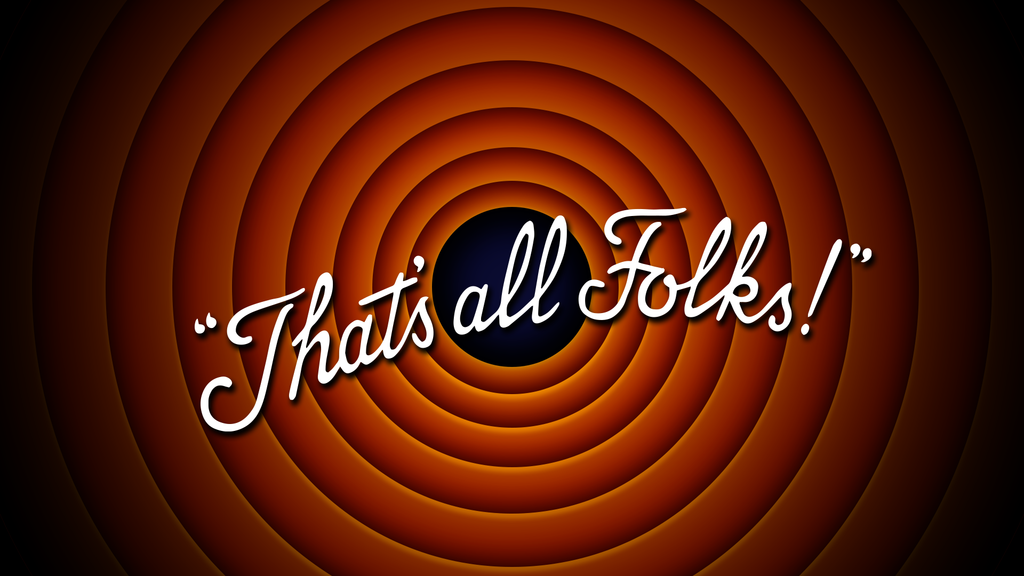